In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr
import os
import pandas as pd
import scipy.stats
import sys
sys.path.insert(1, '/glade/u/home/lettier/analysis/')
import master_utils as myf
xr.set_options(keep_attrs=True)

only have daily SST

In [17]:
myvariables = ['SST']
mytime = pd.date_range(start="1979-01-01",end="2018-12-31", freq='M')
eddir = '/glade/scratch/wriggles/archive/'
mydir = '/glade/work/lettier/NUDGE/'

In [15]:
def wrangle_nudge (nudge_name, myvariables):
    myfiles = sorted([eddir+nudge_name+'/ocn/hist/'+f for f in os.listdir(eddir+nudge_name+'/ocn/hist/')  if '.h.nday1.' in f])
    listds = []
    for f in myfiles:
        ds = xr.open_dataset(f)[['SST']].mean(dim='time')
        listds.append(ds)

    myfiles = sorted([eddir+nudge_name+'_21C/ocn/hist/'+f for f in os.listdir(eddir+nudge_name+'_21C/ocn/hist/') if '.h.nday1.' in f])

    for f in myfiles:
        ds = xr.open_dataset(f)[['SST']].mean(dim='time')
        listds.append(ds)

    ds = xr.concat(listds,dim='time') 
    ds['time'] = mytime
    ds['names'] = nudge_name
    ds = ds.set_coords('names')

    return ds

In [12]:
def wrangle_lens (e, myvariables):
    ledir = '/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/ocn/proc/tseries/monthly/'

    ens = str(e)
    if e<10:
        ens = '0'+str(e)
    tmp = []
    print(ens)
    for var in myvariables:
        myfiles = sorted([ledir+var+'/'+f for f in os.listdir(ledir+var) if ('B20TRC5CNBDRD' in f or 'BRCP85C5CNBDRD' in f) and '0'+ens+'.pop.h.'+var in f ])
        myfiles = [f for f in myfiles if '.192001-199912.nc' not in f and '208101-210012.nc' not in f]
        print(myfiles)
        ds = xr.open_mfdataset(myfiles)[[var]].sel(time=slice('1979-02','2019-01'))
        ds['time'] = mytime
        tmp.append(ds)
    ds = xr.merge(tmp)
    ds['names'] = 'LENS'+ens
    ds = ds.set_coords('names')

    return ds

In [2]:
tarea = xr.open_dataset('/glade/scratch/wriggles/archive/nudge_era_high/ice/hist/nudge_era_high.cice.h.2005-12.nc').tarea
tarea = tarea.rename({'ni':'nlon','nj':'nlat'})
natl_area = tarea.where(tarea.TLAT>0.).where(tarea.TLAT<=60).where(tarea.TLON<=352.5).where(tarea.TLON>285)

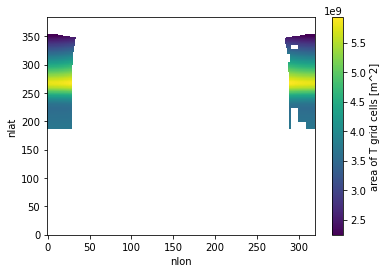

In [3]:
natl_area.plot()

In [18]:
nudge_name = 'nudge_era_high'
ds = (wrangle_nudge(nudge_name, myvariables))
   

In [19]:
ds.isel(time=0)

<xarray.Dataset>
Dimensions:  (nlat: 384, nlon: 320)
Coordinates:
    ULONG    (nlat, nlon) float64 321.1 322.3 323.4 324.5 ... 319.2 319.6 320.0
    ULAT     (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    time     datetime64[ns] 1979-01-31
    names    <U14 'nudge_era_high'
Dimensions without coordinates: nlat, nlon
Data variables:
    SST      (nlat, nlon) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    title:         nudge_era_high
    history:       none
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 58852 2014-04-04 21:28:27Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2020-12-18 at 15:57:02.2
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  25
    tavg_sum:      86400.0

In [ ]:
#nudge era low is missing SST for the 21C part
for nudge_name in ['nudge_era_high', 'qing_era_6','anom_nudge_era','anom_nudge_era_high','anom_nudge_era_low']:
    print(nudge_name)
    ds = (wrangle_nudge(nudge_name, myvariables))
    print(ds)
    ds_avg = (ds*natl_area).sum(dim=('nlat','nlon'))/(natl_area).sum(dim=('nlat','nlon'))
    ds_avg.attrs['desc'] = 'SST averaged over 0-60N, 285-352.5E'
    ds_avg.to_netcdf(mydir+'processed/timeseries/ocn/'+nudge_name+'.ocn_sst_natl.1979-2018.nc')


nudge_era_high
<xarray.Dataset>
Dimensions:  (nlat: 384, nlon: 320, time: 480)
Coordinates:
    ULONG    (nlat, nlon) float64 321.1 322.3 323.4 324.5 ... 319.2 319.6 320.0
    ULAT     (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
  * time     (time) datetime64[ns] 1979-01-31 1979-02-28 ... 2018-12-31
    names    <U14 'nudge_era_high'
Dimensions without coordinates: nlat, nlon
Data variables:
    SST      (time, nlat, nlon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    title:         nudge_era_high
    history:       none
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 58852 2014-04-04 21:28:27Z mlevy@ucar.edu $
    calenda

In [7]:
obds = xr.open_dataset('/glade/work/lettier/HADISST/HadISST_sst.nc').sel(time=slice('1979','2018'))
obds = obds.rename({'sst':'SST'})
obds['names'] = 'HADISST'
obds = obds.set_coords('names')
obds['time'] = mytime

In [5]:
garea = xr.open_dataset('/glade/work/lettier/GRIDS/grid_cell_area_1deg_regular_grid.nc')

In [6]:
natl_area = garea.where(garea.latitude>0.).where(garea.latitude<=60).where(garea.longitude<=-7.5).where(garea.longitude>-75).gridcellarea

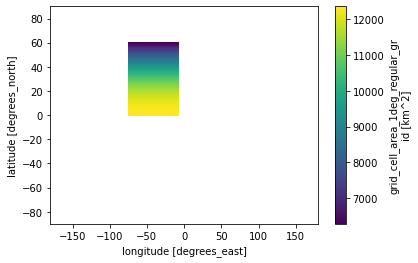

In [7]:
natl_area.plot()

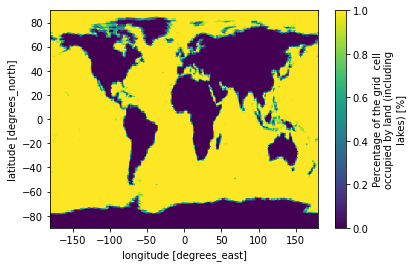

In [8]:
landmask = xr.open_dataset('/glade/work/lettier/HADISST/landmask.nc').sftlf
landmask = 1.-landmask
landmask.plot()

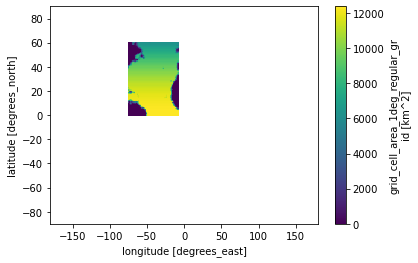

In [9]:
(natl_area*landmask).plot()

In [11]:
(natl_area*landmask).sum()

<xarray.DataArray ()>
array(34546808.81854236)
Attributes:
    units:      km^2
    long_name:  grid_cell_area_1deg_regular_grid

In [25]:
name = str(obds.names.values)
print(type(name))
ds_avg = (obds*natl_area*landmask).sum(dim=('latitude','longitude'))/(natl_area*landmask).sum(dim=('latitude','longitude'))
ds_avg.attrs['desc'] = 'SST averaged over 0-60N, 285-352.5E'
ds_avg.to_netcdf(mydir+'processed/timeseries/ocn/'+name+'.ocn_sst_natl.1979-2018.nc')
print(ds_avg)

<class 'str'>
<xarray.Dataset>
Dimensions:    (nv: 2, time: 480)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-31 1979-02-28 ... 2018-12-31
    names      <U7 'HADISST'
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) float64 3.981e+04 3.984e+04 ... 5.439e+04 5.442e+04
    SST        (time) float64 19.41 18.91 18.82 19.31 ... 23.23 21.86 20.63
Attributes:
    desc:     SST averaged over 0-60N, 285-352.5E


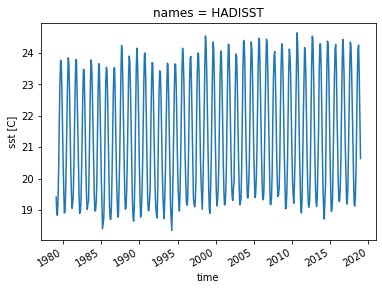

In [26]:
ds_avg.SST.plot()

In [28]:
tarea = xr.open_dataset('/glade/scratch/wriggles/archive/nudge_era_high/ice/hist/nudge_era_high.cice.h.2005-12.nc').tarea
tarea = tarea.rename({'ni':'nlon','nj':'nlat'})
natl_area = tarea.where(tarea.TLAT>0.).where(tarea.TLAT<=60).where(tarea.TLON<=352.5).where(tarea.TLON>285)

In [19]:
for e in range(1,36,1):
    ds = wrangle_lens(e,myvariables)
    name = str(ds.names.values)
    print(name)
    ds_avg = (ds*natl_area).sum(dim=('nlat','nlon'))/(natl_area).sum(dim=('nlat','nlon'))
    ds_avg.attrs['desc'] = 'SST averaged over 0-60N, 285-352.5E'
    ds_avg.to_netcdf(mydir+'processed/timeseries/ocn/'+name+'.ocn_sst_natl.1979-2018.nc')
    print(ds_avg)

01
['/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/ocn/proc/tseries/monthly/SST/b.e11.B20TRC5CNBDRD.f09_g16.001.pop.h.SST.185001-200512.nc', '/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/ocn/proc/tseries/monthly/SST/b.e11.BRCP85C5CNBDRD.f09_g16.001.pop.h.SST.200601-208012.nc']
LENS01
<xarray.Dataset>
Dimensions:  (time: 480, z_t: 1)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-31 1979-02-28 ... 2018-12-31
  * z_t      (z_t) float32 500.0
    names    <U6 'LENS01'
Data variables:
    SST      (time, z_t) float32 dask.array<chunksize=(324, 1), meta=np.ndarray>
Attributes:
    desc:     SST averaged over 0-60N, 285-352.5E
02
['/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/ocn/proc/tseries/monthly/SST/b.e11.B20TRC5CNBDRD.f09_g16.002.pop.h.SST.192001-200512.nc', '/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/ocn/proc/tseries/monthly/SST/b.e11.BRCP85C5CNBDRD.f09_g16.002.pop.h.SST.200601-208012.nc']
LENS02
<xarray.Dataset>
Dimensions:  (time: 480, z_t: 1)
C

In [29]:
listds = []
for e in range(1,36,1):
    ds = wrangle_lens(e,myvariables)
    name = str(ds.names.values)
    ds_avg = (ds*natl_area).sum(dim=('nlat','nlon'))/(natl_area).sum(dim=('nlat','nlon'))
    listds.append(ds_avg)


01
['/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/ocn/proc/tseries/monthly/SST/b.e11.B20TRC5CNBDRD.f09_g16.001.pop.h.SST.185001-200512.nc', '/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/ocn/proc/tseries/monthly/SST/b.e11.BRCP85C5CNBDRD.f09_g16.001.pop.h.SST.200601-208012.nc']
02
['/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/ocn/proc/tseries/monthly/SST/b.e11.B20TRC5CNBDRD.f09_g16.002.pop.h.SST.192001-200512.nc', '/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/ocn/proc/tseries/monthly/SST/b.e11.BRCP85C5CNBDRD.f09_g16.002.pop.h.SST.200601-208012.nc']
03
['/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/ocn/proc/tseries/monthly/SST/b.e11.B20TRC5CNBDRD.f09_g16.003.pop.h.SST.192001-200512.nc', '/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/ocn/proc/tseries/monthly/SST/b.e11.BRCP85C5CNBDRD.f09_g16.003.pop.h.SST.200601-208012.nc']
04
['/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/ocn/proc/tseries/monthly/SST/b.e11.B20TRC5CNBDRD.f09_g16.004.pop.h.SST

In [31]:
meands = xr.concat(listds,dim='names').mean(dim='names')

In [32]:
meands['names'] = 'LENSmean'
meands = meands.set_coords('names')

In [33]:
meands.attrs['desc'] = 'SST averaged over 0-60N, 285-352.5E'
meands.to_netcdf(mydir+'processed/timeseries/ocn/LENSmean.ocn_sst_natl.1979-2018.nc')